In [1]:
import operator
import pdb
import pandas as pd
import numpy as np

import os
filenames = os.listdir('/root/cassandra-stress/')

filenames = [filename for filename in filenames if filename.endswith('log')]
print(filenames)

['read_heap600M_max1100M.log', 'read_heap400M_max700M.log', 'read_heap600M_max700M.log', 'read_heap200M_max700M.log', 'read_heap400M_max900M.log', 'read_heap600M_max900M.log', 'read_heap200M_max900M.log', 'read_heap400M_max1100M.log', 'read_heap200M_max1100M.log']


In [2]:
for iteration,filename in enumerate(filenames):
    with open('/root/cassandra-stress/'+filename) as fl:
        logs = fl.readlines()

    thread_count = []
    for line in logs:
        if line.startswith('Running with '):
            thread_count.append(int(line.split(' ')[2]))
    #print thread_count
    complete_frame = []
    current_frame = []
    for index,line in enumerate(logs):
        if line.startswith('Results'):
            for i in range(1,18):
                if i == 17:
                    minutes =  float(logs[index+i].split(':')[2].lstrip())
                    sec =  float(logs[index+i].split(':')[1].lstrip())
                    extracted_part = minutes* 60 + sec
                else:
                    extracted_part =  logs[index+i].split(':')[1].split('\t')[0].lstrip().split(' ')[0]
                    if ',' in extracted_part: 
                        extracted_part = extracted_part.replace(',','')    
                current_frame.append(float(extracted_part))
            complete_frame.append(current_frame)
            current_frame = []

    complete_frame = pd.DataFrame(complete_frame)
    complete_frame.columns = ['op-rate','partition-rate','row-rate','latency-mean','latency-median','latency-95p','latency-99p','latency-99.99p','latency-max','total-partition','total-errors','total-gc-count','total-memory','total-gc-time','avg-gc-time','stddev-gc-time','total-op-time']
    complete_frame['heap-size'] = int(filename.split('_')[1].split('heap')[1][:-1]) * np.ones((len(complete_frame),1))
    complete_frame['Maxheap-size'] = int(filename.split('_')[2].split('max')[1].split('M')[0]) * np.ones((len(complete_frame),1))
    complete_frame['thread-count'] = thread_count
    if iteration != 0:
        complete_frame = pd.concat([lastiter_frame, complete_frame],ignore_index=True)
    lastiter_frame = complete_frame    
complete_frame.drop('total-partition', axis=1, inplace=True)

print(complete_frame)

     op-rate  partition-rate  row-rate  latency-mean  latency-median  \
0     2732.0          2732.0    2732.0           1.4             1.2   
1     3372.0          3372.0    3372.0           2.4             2.0   
2     4462.0          4462.0    4462.0           3.6             3.0   
3     5346.0          5346.0    5346.0           4.5             3.8   
4     5983.0          5983.0    5983.0           6.0             5.1   
5     6715.0          6715.0    6715.0           8.0             6.7   
6     7521.0          7521.0    7521.0          10.7             8.8   
7     8291.0          8291.0    8291.0          14.6            11.7   
8     8658.0          8658.0    8658.0          20.7            16.8   
9     9400.0          9400.0    9400.0          28.6            24.1   
10    9526.0          9526.0    9526.0          42.4            36.3   
11    9357.0          9357.0    9357.0          64.8            57.0   
12    9100.0          9100.0    9100.0         100.0            

In [3]:
import matplotlib.pyplot as plt
plt.plot(complete_frame['thread-count'][:13], complete_frame['total-op-time'][:13], 'go-', linewidth=2)
plt.xlabel('Number of threads'); plt.ylabel('Read request fulfillment time (sec)')
plt.show()
plt.plot(complete_frame['thread-count'][:13],complete_frame['row-rate'][:13], 'rs-', linewidth=2)
plt.xlabel('Number of threads'); plt.ylabel('Number of rows read/s')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

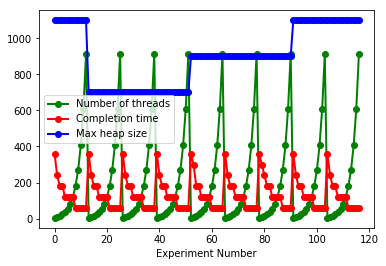

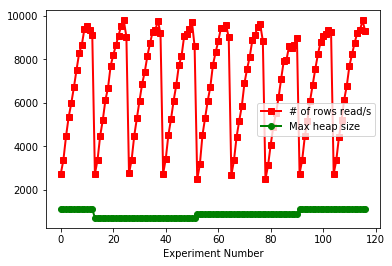

In [4]:
import matplotlib.pyplot as plt
plt.plot(complete_frame['thread-count'], 'go-', linewidth=2, label = 'Number of threads')
plt.plot(complete_frame['total-op-time'], 'ro-', linewidth=2, label = 'Completion time')
plt.plot(complete_frame['Maxheap-size'], 'bo-', linewidth=2, label = 'Max heap size')
plt.xlabel('Experiment Number')
plt.legend()
#plt.xlabel('Number of threads'); plt.ylabel('Read request fulfillment time (sec)')
plt.show()
plt.plot(complete_frame['row-rate'], 'rs-', linewidth=2, label='# of rows read/s')
plt.plot(complete_frame['Maxheap-size'], 'go-', linewidth=2, label = 'Max heap size')
plt.xlabel('Experiment Number')
plt.legend()
#plt.xlabel('Number of threads'); plt.ylabel('Number of rows read')
plt.show()

In [5]:
for i in range(len(complete_frame['thread-count'])):
    if complete_frame['thread-count'][i] < 20:
        complete_frame['thread-count'][i] = 'Below 20'
    elif complete_frame['thread-count'][i] >= 20 and complete_frame['thread-count'][i] < 50:
        complete_frame['thread-count'][i] = '20-49'
    elif complete_frame['thread-count'][i] >= 50 and complete_frame['thread-count'][i] < 100:
        complete_frame['thread-count'][i] = '50-99'
    elif complete_frame['thread-count'][i] >= 100 and complete_frame['thread-count'][i] < 300:
        complete_frame['thread-count'][i] = '100-299'
    elif complete_frame['thread-count'][i] >= 300 and complete_frame['thread-count'][i] < 600:
        complete_frame['thread-count'][i] = '300-599'   
    else:
        complete_frame['thread-count'][i] = '600-and-above'

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist

[LibLinear]0.7659574468085106


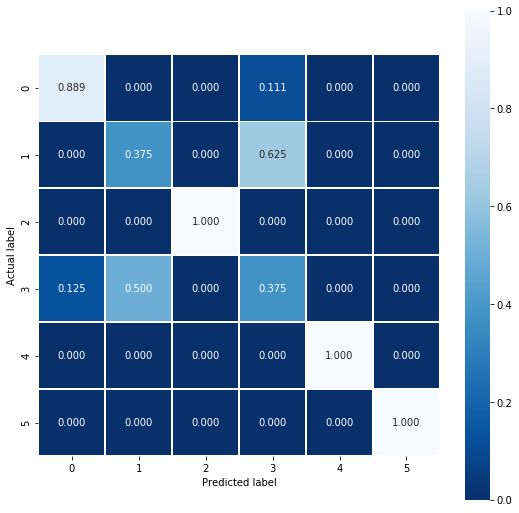

In [6]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

X=complete_frame.values[:,:-1]
Y=complete_frame['thread-count']
cleanup_nums = {'100-299':0, '20-49':1, '300-599':2, '50-99':3, '600-and-above':4, 'Below 20':5}
Y.replace(cleanup_nums,inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
from sklearn.linear_model import LogisticRegression 
logisticRegr = LogisticRegression(solver = 'liblinear',verbose=1)
logisticRegr.fit(X_train,Y_train)
score = logisticRegr.score(X_test , Y_test)
print(score)

# Make predictions on test data
predictions = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(Y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(score) 
plt.show()



In [7]:
complete_frame.columns

Index(['op-rate', 'partition-rate', 'row-rate', 'latency-mean',
       'latency-median', 'latency-95p', 'latency-99p', 'latency-99.99p',
       'latency-max', 'total-errors', 'total-gc-count', 'total-memory',
       'total-gc-time', 'avg-gc-time', 'stddev-gc-time', 'total-op-time',
       'heap-size', 'Maxheap-size', 'thread-count'],
      dtype='object')

In [16]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

# Data params
input_dim = 18
output_dim = 6

# Network params
n_hidden_units = 51
activation_fn = tf.nn.relu

# Optimization params
batch_size = 10
epochs_per_task = 10

n_stats = 10

# Reset optimizer after each age
reset_optimizer = True

from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[1,4], [0,9], [7,8], [3,6], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5]]
n_tasks = len(task_labels)
nb_classes  = 6
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_train[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
    else:
        data = X_train[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(Y_test, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_test[idx], np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
    else:
        data = X_test[idx], np_utils.to_categorical(Y_test[idx], nb_classes)
        validation_datasets.append(data)
        
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    sess.run(output_mask)
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(input_dim,)))
model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax))

from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
#opt = SGD(1e-3)
#opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
#history = History()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

print(protocol)

def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[print_weights])
                save_loss_epoch.append(stuffs.history['loss'])
                #if age != 0:
                    #model_prune(age, unimportant_threshold = 5)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save

cvals = [0, 1.0]
print(cvals)

np.random.seed(0)
recompute_data = True

if recompute_data:
    data,model_weights_save = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['average', 'select', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
  0%|          | 0/2 [00:00<?, ?it/s]

{'step_updates': [('grads2', <function <lambda>.<locals>.<lambda> at 0x7fd021d96730>)], 'task_updates': [('omega', <function <lambda>.<locals>.<lambda> at 0x7fd021d96d08>), ('cweights', <function <lambda>.<locals>.<lambda> at 0x7fd021d96bf8>), ('grads2', <function <lambda>.<locals>.<lambda> at 0x7fd021d96c80>)], 'regularizer_fn': <function quadratic_regularizer at 0x7fd030d87378>, 'init_updates': [('cweights', <function <lambda>.<locals>.<lambda> at 0x7fd021d96b70>)]}
[0, 1.0]
setting cval
cval is 0.0
Age 0, cval is=0.000000
settint output mask
Epoch 1/10
28/28 [==============================] - 0s - loss: 2.3113 - acc: 0.4286     
Epoch 2/10
28/28 [==============================] - 0s - loss: 1.9640 - acc: 0.6429     
Epoch 3/10
28/28 [==============================] - 0s - loss: 2.4460 - acc: 0.6429     
Epoch 4/10
28/28 [==============================] - 0s - loss: 1.0412 - acc: 0.6429     
Epoch 5/10
28/28 [==============================] - 0s - loss: 1.0079 - acc: 0.3571     
Epoc

27/27 [==============================] - 0s - loss: 1.3447 - acc: 0.2963     
Epoch 3/10
27/27 [==============================] - 0s - loss: 0.7876 - acc: 0.5926     
Epoch 4/10
27/27 [==============================] - 0s - loss: 0.2671 - acc: 0.8519     
Epoch 5/10
27/27 [==============================] - 0s - loss: 0.2866 - acc: 0.8889     
Epoch 6/10
27/27 [==============================] - 0s - loss: 0.0933 - acc: 1.0000     
Epoch 7/10
27/27 [==============================] - 0s - loss: 0.1062 - acc: 0.9630     
Epoch 8/10
27/27 [==============================] - 0s - loss: 0.0380 - acc: 1.0000     
Epoch 9/10
27/27 [==============================] - 0s - loss: 0.0417 - acc: 1.0000     
Epoch 10/10
27/27 [==============================] - 0s - loss: 0.0226 - acc: 1.0000     
setting cval
cval is 0.0
Age 0, cval is=0.000000
settint output mask
Epoch 1/10
28/28 [==============================] - 0s - loss: 3.3369 - acc: 0.5357     
Epoch 2/10
28/28 [==============================] -

15/15 [==============================] - 0s - loss: 0.9395 - acc: 0.3333     
Epoch 9/10
15/15 [==============================] - 0s - loss: 0.6263 - acc: 0.6667     
Epoch 10/10
15/15 [==============================] - 0s - loss: 0.6762 - acc: 0.6667     
Age 2, cval is=0.000000
settint output mask
Epoch 1/10
27/27 [==============================] - 0s - loss: 0.7462 - acc: 0.4074     
Epoch 2/10
27/27 [==============================] - 0s - loss: 0.5965 - acc: 0.4444     
Epoch 3/10
27/27 [==============================] - 0s - loss: 0.4738 - acc: 0.7778     
Epoch 4/10
27/27 [==============================] - 0s - loss: 0.3965 - acc: 0.9630     
Epoch 5/10
27/27 [==============================] - 0s - loss: 0.2875 - acc: 0.9259     
Epoch 6/10
27/27 [==============================] - 0s - loss: 0.1891 - acc: 1.0000     
Epoch 7/10
27/27 [==============================] - 0s - loss: 0.1306 - acc: 1.0000     
Epoch 8/10
27/27 [==============================] - 0s - loss: 0.0989 - acc:

15/15 [==============================] - 0s - loss: 0.8964 - acc: 0.4000     
Epoch 5/10
15/15 [==============================] - 0s - loss: 1.1836 - acc: 0.6667     
Epoch 6/10
15/15 [==============================] - 0s - loss: 0.4228 - acc: 0.6667     
Epoch 7/10
15/15 [==============================] - 0s - loss: 1.6392 - acc: 0.3333     
Epoch 8/10
15/15 [==============================] - 0s - loss: 1.1325 - acc: 0.2667     
Epoch 9/10
15/15 [==============================] - 0s - loss: 0.8784 - acc: 0.6667     
Epoch 10/10
15/15 [==============================] - 0s - loss: 0.5855 - acc: 0.6667     
Age 2, cval is=0.000000
settint output mask
Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 2.7718 - acc: 0.800 - 0s - loss: 3.2103 - acc: 0.5556     
Epoch 2/10
27/27 [==============================] - 0s - loss: 0.9034 - acc: 0.5926     
Epoch 3/10
27/27 [==============================] - 0s - loss: 1.1438 - acc: 0.4444     
Epoch 4/10
27/27 [====================

 50%|█████     | 1/2 [00:10<00:10, 10.00s/it]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
28/28 [==============================] - 0s - loss: 4.0099 - acc: 0.4286     
Epoch 2/10
28/28 [==============================] - 0s - loss: 1.7748 - acc: 0.6429     
Epoch 3/10
28/28 [==============================] - 0s - loss: 0.8727 - acc: 0.4286     
Epoch 4/10
28/28 [==============================] - 0s - loss: 0.4812 - acc: 0.7857     
Epoch 5/10
28/28 [==============================] - 0s - loss: 0.6768 - acc: 0.6429     
Epoch 6/10
28/28 [==============================] - 0s - loss: 0.4938 - acc: 0.8929     
Epoch 7/10
28/28 [==============================] - 0s - loss: 0.4512 - acc: 0.7857     
Epoch 8/10
28/28 [==============================] - 0s - loss: 0.4476 - acc: 0.6429     
Epoch 9/10
28/28 [==============================] - 0s - loss: 0.4483 - acc: 0.9643     
Epoch 10/10
28/28 [==============================] - 0s - loss: 0.4995 - acc: 0.7143     
Age 1, cval is=1.000000
settint output m

27/27 [==============================] - 0s - loss: 0.0278 - acc: 1.0000     
Epoch 8/10
27/27 [==============================] - 0s - loss: 0.0215 - acc: 1.0000     
Epoch 9/10
27/27 [==============================] - 0s - loss: 0.0207 - acc: 1.0000     
Epoch 10/10
27/27 [==============================] - 0s - loss: 0.0209 - acc: 1.0000     
setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
28/28 [==============================] - 0s - loss: 2.1355 - acc: 0.5000     
Epoch 2/10
28/28 [==============================] - 0s - loss: 2.0651 - acc: 0.6429     
Epoch 3/10
28/28 [==============================] - 0s - loss: 1.9582 - acc: 0.6429     
Epoch 4/10
28/28 [==============================] - 0s - loss: 1.3042 - acc: 0.3571     
Epoch 5/10
28/28 [==============================] - 0s - loss: 0.9787 - acc: 0.3571     
Epoch 6/10
28/28 [==============================] - 0s - loss: 1.0721 - acc: 0.6429     
Epoch 7/10
28/28 [==============================] -

27/27 [==============================] - 0s - loss: 0.6849 - acc: 0.4815     
Epoch 4/10
27/27 [==============================] - 0s - loss: 0.3285 - acc: 0.9259     
Epoch 5/10
27/27 [==============================] - 0s - loss: 0.2069 - acc: 0.9630     
Epoch 6/10
27/27 [==============================] - 0s - loss: 0.1248 - acc: 0.9630     
Epoch 7/10
27/27 [==============================] - 0s - loss: 0.0557 - acc: 1.0000     
Epoch 8/10
27/27 [==============================] - 0s - loss: 0.0561 - acc: 1.0000     
Epoch 9/10
27/27 [==============================] - 0s - loss: 0.0523 - acc: 0.9630     
Epoch 10/10
27/27 [==============================] - 0s - loss: 0.0444 - acc: 1.0000     
setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
28/28 [==============================] - 0s - loss: 2.3404 - acc: 0.4286     
Epoch 2/10
28/28 [==============================] - 0s - loss: 1.9986 - acc: 0.6429     
Epoch 3/10
28/28 [==============================] -

15/15 [==============================] - 0s - loss: 0.7324 - acc: 0.6667     
Age 2, cval is=1.000000
settint output mask
Epoch 1/10
27/27 [==============================] - 0s - loss: 5.1097 - acc: 0.4444     
Epoch 2/10
27/27 [==============================] - 0s - loss: 0.8784 - acc: 0.6667     
Epoch 3/10
27/27 [==============================] - 0s - loss: 0.6561 - acc: 0.5926     
Epoch 4/10
27/27 [==============================] - 0s - loss: 0.3468 - acc: 0.8519     
Epoch 5/10
27/27 [==============================] - 0s - loss: 0.2423 - acc: 0.8889     
Epoch 6/10
27/27 [==============================] - 0s - loss: 0.2747 - acc: 0.8889     
Epoch 7/10
27/27 [==============================] - 0s - loss: 0.0809 - acc: 1.0000     
Epoch 8/10
27/27 [==============================] - 0s - loss: 0.1105 - acc: 0.9630     
Epoch 9/10
27/27 [==============================] - 0s - loss: 0.1037 - acc: 0.9630     
Epoch 10/10
27/27 [==============================] - 0s - loss: 0.0749 - acc:

100%|██████████| 2/2 [00:20<00:00, 10.12s/it]


In [17]:
import h5py
print(model.summary())
model.save_weights('saved_weights.h5') #This file cannot be opend normaly to view the weghts. It can be loaded through load_model() or can be opend via hdf5 viewer

#Shape of the array containg model weights
a_list = model.get_weights()
for i in range(len(a_list)):
    print((np.array(a_list[i])).shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 51)                969       
_________________________________________________________________
dense_2 (Dense)              (None, 51)                2652      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 312       
Total params: 3,933
Trainable params: 3,933
Non-trainable params: 0
_________________________________________________________________
None
(18, 51)
(51,)
(51, 51)
(51,)
(51, 6)
(6,)


In [29]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0

print(data)


[0, 1.0]
{'mean': {0: array([[0.61176471, 0.        , 0.        ],
       [0.59411765, 0.4       , 0.        ],
       [0.49411765, 0.4       , 0.98888889]]), 1.0: array([[0.62352941, 0.        , 0.        ],
       [0.59411765, 0.5       , 0.        ],
       [0.62941176, 0.51666667, 1.        ]])}, 'std': {0: array([[0.12941176, 0.        , 0.        ],
       [0.15440476, 0.15898987, 0.        ],
       [0.07058824, 0.2       , 0.03333333]]), 1.0: array([[0.13465321, 0.        , 0.        ],
       [0.11299631, 0.17873009, 0.        ],
       [0.17459791, 0.18929694, 0.        ]])}}


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(-5.0, 0.0)


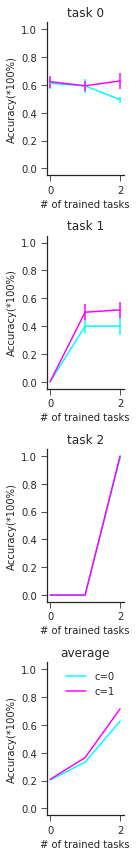

In [33]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

figure(figsize=(2, 12))
axs = [subplot(n_tasks+1,1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(n_tasks+1,1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
    ax.set_xlabel('# of trained tasks')
    ax.set_ylabel('Accuracy(*100%)')
gcf().tight_layout()
sns.despine()